In [1]:
import csv
import math
import datetime
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import log_loss
from dateutil.relativedelta import relativedelta

In [2]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv", index_col=0)
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch

,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances
ID,,,,,,,,,,,,
6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916
6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277
6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531
6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564
6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199
...,...,...,...,...,...,...,...,...,...,...,...,...
20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251
20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825
20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966


jubilo-iwataのホームでの平均得点 : 1.2352941176470589
jubilo-iwataのホームでの平均失点 : 1.588235294117647
shimizu-s-pulseのアウェイでの平均得点 : 1.411764705882353
shimizu-s-pulseのアウェイでの平均失点 : 1.8823529411764706
リーグ全体のホームでの平均得点 : 1.416403785488959
リーグ全体のアウェイでの平均得点 : 1.2712933753943219
HA:0.8721341543298834, AA:1.1104948182747043, HD:1.2493066705590423, AD:1.3289663304074413, 
得点予測  jubilo-iwata 1.64 - 1.76 shimizu-s-pulse


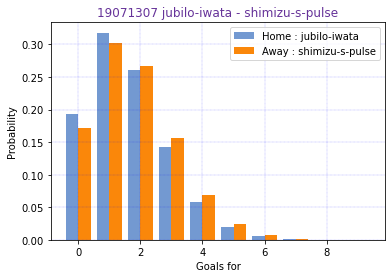

jubilo-iwata - shimizu-s-pulse
win 36.18%
loss 41.24%
draw 22.58%


In [33]:
match_id=19071307
match_range = 17

current_day = df_allmatch.at[match_id,"Date"]
home = df_allmatch.at[match_id,"Home"]
away = df_allmatch.at[match_id,"Away"]

df_recent_home = df_allmatch[
    (df_allmatch["Date"] < current_day) &
    ((current_day.year-1)<= df_allmatch["Year"]) &
    (df_allmatch["Home"] == home) 
].tail(match_range)

if  (match_range- len(df_recent_home)) :
    for _ in range(match_range- len(df_recent_home)):
        df_recent_home = df_recent_home.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 0.99, 'AwayGF': 1.66}, ignore_index=True)

df_recent_away = df_allmatch[
    (df_allmatch["Date"] < current_day) &
    ((current_day.year-1)<= df_allmatch["Year"]) &
    (df_allmatch["Away"] == away)
].tail(match_range)

if  (match_range- len(df_recent_away)) :
    for _ in range(match_range- len(df_recent_away)):
        df_recent_away = df_recent_away.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 1.83, 'AwayGF': 0.94}, ignore_index=True)

beginning_day = min(df_recent_home.iloc[0,2],df_recent_away.iloc[0,2])

df_recent = df_allmatch[
    (beginning_day <= df_allmatch["Date"] ) &
    (df_allmatch["Date"] < current_day) 
]

homegf_ave = df_recent_home["HomeGF"].mean()
homega_ave = df_recent_home["AwayGF"].mean()
awaygf_ave = df_recent_away["AwayGF"].mean()
awayga_ave = df_recent_away["HomeGF"].mean()
homegf_league_ave = df_recent["HomeGF"].mean()
awaygf_league_ave = df_recent["AwayGF"].mean()

print(f"{home}のホームでの平均得点 : {homegf_ave}")
print(f"{home}のホームでの平均失点 : {homega_ave}")
print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")

home_attack = homegf_ave / homegf_league_ave
away_defense = awayga_ave / homegf_league_ave
homegf_pred = home_attack * away_defense * homegf_league_ave

away_attack = awaygf_ave / awaygf_league_ave
home_defense = homega_ave / awaygf_league_ave
awaygf_pred = away_attack * home_defense * awaygf_league_ave

print(f"HA:{home_attack}, AA:{away_attack}, HD:{home_defense}, AD:{away_defense}, ")

print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")

x =  np.arange(0, 10, 1)

home_poisson = poisson.pmf(x, homegf_pred)
away_poisson = poisson.pmf(x, awaygf_pred)


plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#7399D1", label=f'Home : {home}')
plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#FA870A", label=f'Away : {away}')

plt.xlabel('Goals for')
plt.ylabel('Probability')
plt.grid(color='b', linestyle=':', linewidth=0.3)
plt.title(f"{match_id} {home} - {away}", color='rebeccapurple')
plt.legend()
plt.show()

df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])


win_prob_sum = 0
loss_prob_sum = 0
draw_prob_sum = 0

for gf in x:
    gf_prob = df_poisson.at[home, gf]
    for ga in x:
        ga_prob = df_poisson.at[away,ga]
        score_prob = gf_prob * ga_prob

        if gf>ga:
            win_prob_sum += score_prob
        elif gf<ga:
            loss_prob_sum += score_prob
        else:
            draw_prob_sum += score_prob

prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
win_prob_sum = win_prob_sum/prob_sum
loss_prob_sum = loss_prob_sum/prob_sum
draw_prob_sum = draw_prob_sum/prob_sum

print(f"{home} - {away}")
print(f"win {win_prob_sum:.2%}")
print(f"loss {loss_prob_sum:.2%}")
print(f"draw {draw_prob_sum:.2%}")

# return draw_prob_sum,win_prob_sum,loss_prob_sum

In [36]:
round(df_poisson,3)

,0,1,2,3,4,5,6,7,8,9
jubilo-iwata,0.194,0.318,0.261,0.143,0.059,0.019,0.005,0.001,0.0,0.0
shimizu-s-pulse,0.171,0.302,0.267,0.157,0.069,0.024,0.007,0.002,0.0,0.0


In [41]:
def predict_with_poisson(match_id, match_range = 17):

    current_day = df_allmatch.at[match_id,"Date"]
    home = df_allmatch.at[match_id,"Home"]
    away = df_allmatch.at[match_id,"Away"]
    
    df_recent_home = df_allmatch[
        (df_allmatch["Date"] < current_day) &
        ((current_day.year-1)<= df_allmatch["Year"]) &
        (df_allmatch["Home"] == home) 
    ].tail(match_range)

    if  (match_range- len(df_recent_home)) :
        for _ in range(match_range- len(df_recent_home)):
            df_recent_home = df_recent_home.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 0.99, 'AwayGF': 1.66}, ignore_index=True)

    df_recent_away = df_allmatch[
        (df_allmatch["Date"] < current_day) &
        ((current_day.year-1)<= df_allmatch["Year"]) &
        (df_allmatch["Away"] == away)
    ].tail(match_range)

    if  (match_range- len(df_recent_away)) :
        for _ in range(match_range- len(df_recent_away)):
            df_recent_away = df_recent_away.append({'Date':(current_day-relativedelta(days=1)) , 'HomeGF': 1.83, 'AwayGF': 0.94}, ignore_index=True)

    beginning_day = min(df_recent_home.iloc[0,2],df_recent_away.iloc[0,2])

    df_recent = df_allmatch[
        (beginning_day <= df_allmatch["Date"] ) &
        (df_allmatch["Date"] < current_day) 
    ]

    homegf_ave = df_recent_home["HomeGF"].mean()
    homega_ave = df_recent_home["AwayGF"].mean()
    awaygf_ave = df_recent_away["AwayGF"].mean()
    awayga_ave = df_recent_away["HomeGF"].mean()
    homegf_league_ave = df_recent["HomeGF"].mean()
    awaygf_league_ave = df_recent["AwayGF"].mean()
    
#     print(f"{home}のホームでの平均得点 : {homegf_ave}")
#     print(f"{home}のホームでの平均失点 : {homega_ave}")
#     print(f"{away}のアウェイでの平均得点 : {awaygf_ave}")
#     print(f"{away}のアウェイでの平均失点 : {awayga_ave}")
#     print(f"リーグ全体のホームでの平均得点 : {homegf_league_ave}")
#     print(f"リーグ全体のアウェイでの平均得点 : {awaygf_league_ave}")
    
    home_attack = homegf_ave / homegf_league_ave
    away_defense = awayga_ave / homegf_league_ave
    homegf_pred = home_attack * away_defense * homegf_league_ave
    
    away_attack = awaygf_ave / awaygf_league_ave
    home_defense = homega_ave / awaygf_league_ave
    awaygf_pred = away_attack * home_defense * awaygf_league_ave
    
#     print(f"HA:{home_attack}, AA:{away_attack}, HD:{home_defense}, AD:{away_defense}, ")

#     print(f"得点予測  {home} {homegf_pred:.2f} - {awaygf_pred:.2f} {away}")
    
    x =  np.arange(0, 10, 1)

    home_poisson = poisson.pmf(x, homegf_pred)
    away_poisson = poisson.pmf(x, awaygf_pred)


#     plt.bar(x, home_poisson, align="edge", width=-0.4,  color="#7399D1", label=f'Home : {home}')
#     plt.bar(x, away_poisson, align="edge", width= 0.4,  color="#FA870A", label=f'Away : {away}')

#     plt.xlabel('Goals for')
#     plt.ylabel('Probability')
#     plt.grid(color='b', linestyle=':', linewidth=0.3)
#     plt.title(f"{match_id} {home} - {away}", color='rebeccapurple')
#     plt.legend()
#     plt.show()

    df_poisson = pd.DataFrame([home_poisson,away_poisson],columns=x, index=[home,away])
    
    
    win_prob_sum = 0
    loss_prob_sum = 0
    draw_prob_sum = 0
    
    for gf in x:
        gf_prob = df_poisson.at[home, gf]
        for ga in x:
            ga_prob = df_poisson.at[away,ga]
            score_prob = gf_prob * ga_prob

            if gf>ga:
                win_prob_sum += score_prob
            elif gf<ga:
                loss_prob_sum += score_prob
            else:
                draw_prob_sum += score_prob

    prob_sum = win_prob_sum+loss_prob_sum+draw_prob_sum
    win_prob_sum = win_prob_sum/prob_sum
    loss_prob_sum = loss_prob_sum/prob_sum
    draw_prob_sum = draw_prob_sum/prob_sum

#     print(f"{home} - {away}")
#     print(f"win {win_prob_sum:.2%}")
#     print(f"loss {loss_prob_sum:.2%}")
#     print(f"draw {draw_prob_sum:.2%}")

    return draw_prob_sum,win_prob_sum,loss_prob_sum

In [42]:
predict_with_poisson(19071307)

(0.22582333767491594, 0.3617548608605765, 0.4124218014645075)

In [42]:
loglosses = []
accuracies = []
calibrations = []
draw_pred_count = 0
draw_correct_count = 0

for y in range(2015,2021):
    df_pred = pd.DataFrame(index=df_allmatch[df_allmatch["Year"] == y].index, columns=[0,1,2,"pred","actual"])
    correct_count = 0
    y_test = []
    y_pred_proba = []
    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for index, row in df_pred.iterrows():   

        d_pred = predict_with_poisson(index)[0]
        w_pred = predict_with_poisson(index)[1]
        l_pred = predict_with_poisson(index)[2]

        if max(predict_with_poisson(index)) == w_pred:
            wl_pred = 1
        elif max(predict_with_poisson(index)) == l_pred:
            wl_pred = 2
        else:
            wl_pred = 0
            draw_pred_count += 1

        actual = df_allmatch.at[index, "W/L"]
        

        row[0] = d_pred
        row[1] = w_pred
        row[2] = l_pred
        row["pred"] = wl_pred
        row["actual"] = actual
        
        y_pred_proba.append([d_pred,w_pred,l_pred])
        y_test.append(actual)
        
        if wl_pred == actual:
            correct_count += 1
            if actual == 0:
                draw_correct_count += 1
                

        if wl_pred == 1:
            pred_winrate_sum += w_pred
            if actual == 1:
                actual_win_sum += 1
        elif wl_pred == 2:
            pred_winrate_sum += l_pred
            if actual == 2:
                actual_win_sum += 1
                
    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    accuracy = correct_count/len(df_pred)
    accuracies.append(accuracy)
    print(f"{y} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")
    
print("==============================================")
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration) :{np.mean(calibrations):.3f} " )




2015 的中率:0.480, 対数損失:1.052, 較正値:1.085
2016 的中率:0.474, 対数損失:1.056, 較正値:1.128
2017 的中率:0.461, 対数損失:1.081, 較正値:1.139
2018 的中率:0.431, 対数損失:1.129, 較正値:1.196
2019 的中率:0.448, 対数損失:1.090, 較正値:1.105
2020 的中率:0.477, 対数損失:1.067, 較正値:1.105
的中率(Accuracy) : 0.462
対数損失(Log loss) : 1.079
較正値(Calibration) :1.126 


### 考察

 ポアソン分布に関してもAccuracyは46%程度とほぼ変わらず. 
 Logloss,calibrationに関しては,RFより少し劣るが,結構同等レベルまで予測できている.
 
 この手法だと平均得点/失点を取得する日時の範囲を広げれば広げるほどに精度が向上していく.理由は明確にわかっていないが,日時の範囲を広げれば極端な予測をしなくなる分,精度が向上していったのだと考えられる.
 
 ただ,この手法はRFに比べ予測数値の算出のプロセスが分かりやすいのが魅力でもあり,ある程度極端な予測でも良いのではと思う. 得点別の予測確率なんかはRFでは出せないため,この手法も活かせる.

### ======================================================================================

In [21]:
for mrange in [10,20,30,40,50,60,70,80]:
    

    loglosses = []
    accuracies = []
    draw_pred_count = 0
    draw_correct_count = 0

    for y in range(2013,2021):
        df_pred = pd.DataFrame(index=df_allmatch[df_allmatch["Year"] == y].index, columns=[0,1,2,"pred","actual"])

        pred_winrate_sum=0 # 予測勝率の和
        actual_win_sum=0 # 実勝利数の和

        pred_drawrate_sum=0 # 予測引き分け率の和
        actual_draw_sum=0 # 実引き分け数の和

        pred_lossrate_sum=0 # 予測敗率の和
        actual_loss_sum=0 # 実敗北数の和

        error_squares = []
        correct_count = 0

        y_test = []
        y_pred_proba = []

        for index, row in df_pred.iterrows():   

            d_pred = predict_with_poisson(index,mrange)[0]
            w_pred = predict_with_poisson(index,mrange)[1]
            l_pred = predict_with_poisson(index,mrange)[2]

            if max(predict_with_poisson(index,mrange)) == w_pred:
                wl_pred = 1
            elif max(predict_with_poisson(index,mrange)) == l_pred:
                wl_pred = 2
            else:
                wl_pred = 0
                draw_pred_count += 1

            actual = df_allmatch.at[index, "W/L"]


            row[0] = d_pred
            row[1] = w_pred
            row[2] = l_pred
            row["pred"] = wl_pred
            row["actual"] = actual

            y_pred_proba.append([d_pred,w_pred,l_pred])
            y_test.append(actual)

            if wl_pred == actual:
                correct_count += 1
                if actual == 0:
                    draw_correct_count += 1

            if wl_pred == 1:
                pred_winrate_sum += w_pred
                pred_lossrate_sum += l_pred
                pred_drawrate_sum += d_pred

                if actual == 1:
                    actual_win_sum += 1
                elif actual == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

            elif wl_pred == 2:
                pred_winrate_sum += l_pred
                pred_lossrate_sum += w_pred
                pred_drawrate_sum += d_pred

                if actual == 2:
                    actual_win_sum += 1
                elif actual == 0:
                    actual_draw_sum += 1
                else:
                    actual_loss_sum += 1

        logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
        loglosses.append(logloss)

        calibration = pred_winrate_sum/actual_win_sum
        error_square = ((1-calibration)*100)**2
        error_squares.append(error_square)
        accuracies.append(correct_count/len(df_pred))
    #     print(f"{y} 的中率:{correct_count/len(df_pred):.3f}, 対数損失:{logloss:.3f},較正値:{calibration:.3f}")


    print("=============================================")
    print(f"試合数の範囲 : {mrange}")
    print(f"的中率(Accuracy)の平均値 : {np.mean(accuracies):.3f}" )
    print(f"対数損失(Log loss)の平均値 : {np.mean(loglosses):.3f}" )
    print(f"誤差の2乗の平均値 : {np.mean(error_squares):.3f} (平方根:{math.sqrt(np.mean(error_squares)):.3f}) " )




試合数の範囲 : 10
的中率(Accuracy)の平均値 : 0.455
対数損失(Log loss)の平均値 : 1.096
誤差の2乗の平均値 : 330.983 (平方根:18.193) 
試合数の範囲 : 20
的中率(Accuracy)の平均値 : 0.464
対数損失(Log loss)の平均値 : 1.068
誤差の2乗の平均値 : 27.010 (平方根:5.197) 
試合数の範囲 : 30
的中率(Accuracy)の平均値 : 0.464
対数損失(Log loss)の平均値 : 1.053
誤差の2乗の平均値 : 8.127 (平方根:2.851) 
試合数の範囲 : 40
的中率(Accuracy)の平均値 : 0.467
対数損失(Log loss)の平均値 : 1.050
誤差の2乗の平均値 : 9.235 (平方根:3.039) 
試合数の範囲 : 50
的中率(Accuracy)の平均値 : 0.466
対数損失(Log loss)の平均値 : 1.047
誤差の2乗の平均値 : 3.986 (平方根:1.997) 
試合数の範囲 : 60
的中率(Accuracy)の平均値 : 0.464
対数損失(Log loss)の平均値 : 1.048
誤差の2乗の平均値 : 10.589 (平方根:3.254) 
試合数の範囲 : 70
的中率(Accuracy)の平均値 : 0.467
対数損失(Log loss)の平均値 : 1.047
誤差の2乗の平均値 : 4.971 (平方根:2.230) 
試合数の範囲 : 80
的中率(Accuracy)の平均値 : 0.465
対数損失(Log loss)の平均値 : 1.047
誤差の2乗の平均値 : 0.077 (平方根:0.277) 


試合の範囲を広げれば広げるほど,Loglossが減少していく. 
どこでLoglossの減少がどこで止まるかを突き止めたい.(80試合分まで伸ばしたところで概ね収束しているかな?)
しかし,めっちゃ時間がかかる